In [ ]:
# default_exp models.weibull

# Weibull Model
> AFT Models - Weibull distribution

In [ ]:
#export
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [ ]:
# hide
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
from torchlife.data import create_db
import pandas as pd

url = "https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/survival/flchain.csv"
# url = "https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/HSAUR/mastectomy.csv"
df = pd.read_csv(url).iloc[:,1:]
df.rename(columns={'futime':'t', 'death':'e'}, inplace=True)
df['t'] = df['t'] / df['t'].max()

db = create_db(df[['t', 'e']])

print(df.shape)
df.head()

(7874, 11)


,age,sex,sample.yr,kappa,lambda,flc.grp,creatinine,mgus,t,e,chapter
0,97,F,1997,5.70,4.860,10,1.7,0,0.016299,1,Circulatory
1,92,F,2000,0.87,0.683,1,0.9,0,0.245638,1,Neoplasms
2,94,F,1997,4.36,3.850,10,1.4,0,0.013231,1,Circulatory
3,92,F,1996,2.42,2.220,9,1.0,0,0.022052,1,Circulatory
4,93,F,1996,1.32,1.690,6,1.1,0,0.199233,1,Circulatory


In [ ]:
# export
class Weibull(nn.Module):
    def __init__(self, dim:int=0, h:tuple=()):
        super().__init__()
        self.μ = nn.Parameter(-torch.rand(1))
        if dim > 0:
            nodes = (dim,) + h + (1,)
            self.layers = nn.ModuleList([nn.Linear(a,b, bias=False) 
                                       for a,b in zip(nodes[:-1], nodes[1:])])
        
    def gumbel_logpdf(self, t:torch.Tensor, μ:torch.Tensor):
        z = t - μ
        return - (z + torch.exp(-z))

    def gumbel_logcdf(self, t:torch.Tensor, μ:torch.Tensor):
#         breakpoint()
        z = t - μ
        cdf = 1 - torch.exp(-torch.exp(-z))
        return torch.log(cdf)

    def forward(self, t:torch.Tensor, x:torch.Tensor=None):
        # get the Kaplan Meier estimates
        mu = self.μ
        if x:
            for layer in self.layers[:-1]:
                x = F.relu(layer(x))
            mu += self.layers[-1](x)
        mu = torch.exp(mu)
        
        logpdf = self.gumbel_logpdf(t, mu)
        logcdf = self.gumbel_logcdf(t, mu)
        return logpdf, logcdf
    
    def plot_survival_function(self, t:torch.Tensor, x:torch.Tensor=None):
        with torch.no_grad():
            # calculate cumulative hazard according to above
            _, Λ = self.forward(t, x)
            surv_fun = torch.exp(Λ)
        
        # plot
        plt.figure(figsize=(12,5))
        plt.plot(t, surv_fun)
        plt.xlabel('Time')
        plt.ylabel('Survival Probability')
        plt.show()

epoch,train_loss,valid_loss,time
0,0.813731,#na#,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


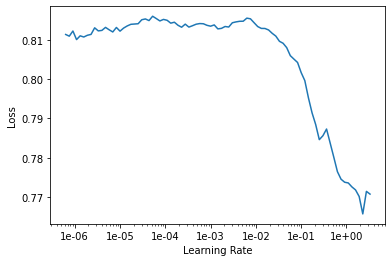

In [ ]:
# hide
from fastai.basics import Learner
from torchlife.losses import aft_loss

# x_dim = df.shape[1] - 2
model = Weibull()
learner = Learner(db, model, loss_func=aft_loss)
# wd = 1e-4
learner.lr_find()
learner.recorder.plot()

In [ ]:
learner.fit(epochs=10, lr=0.5)

epoch,train_loss,valid_loss,time
0,0.673399,0.347782,00:00
1,0.667584,0.433840,00:00
2,0.670483,0.383217,00:00
3,0.665098,0.381907,00:00
4,0.662499,0.422628,00:00
5,0.663273,0.381587,00:00
6,0.663954,0.519372,00:00
7,0.664967,0.410284,00:00
8,0.664776,0.354344,00:00
9,0.665684,0.336361,00:00


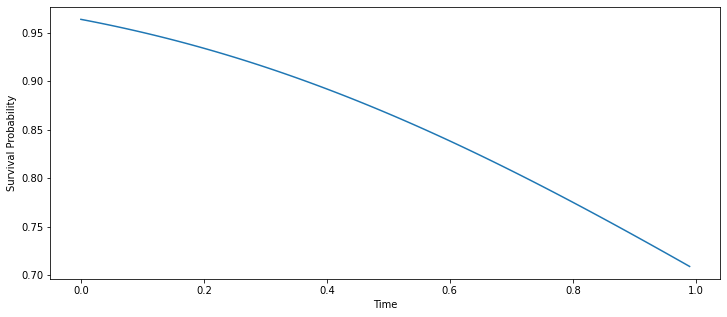

In [ ]:
model.plot_survival_function(torch.arange(0, 1, 0.01))

In [ ]:
# hide
from nbdev.export import *
notebook2script()

Converted AFT_models.ipynb.
Converted Cox_Proportional_Hazard.ipynb.
Converted KaplanMeier.ipynb.
Converted Losses.ipynb.
Converted PiecewiseHazard.ipynb.
Converted Survival Analysis Theory.ipynb.
Converted Weibull_Model.ipynb.
Converted data.ipynb.
Converted index.ipynb.
Converted model.ipynb.
